In [1]:
import numpy as np # linear algebra
import pandas as pd

from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection, preprocessing
import xgboost as xgb
color = sns.color_palette()
sns.set()

%matplotlib inline

import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

from funcs import correct_macro_df, get_corr_empty_info, prepare_choosed_features

pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

In [38]:
# train_df = pd.read_csv("data/train.csv")

# macro_df = pd.read_csv("data/macro.csv")
# macro_df['date'] = pd.to_datetime(macro_df['timestamp'])

train_df = pd.read_csv("data/train.csv", parse_dates=['timestamp'])
test_df = pd.read_csv("data/test.csv", parse_dates=['timestamp'])
macro_df = pd.read_csv("data/macro.csv", parse_dates=['timestamp'])

macro_df = correct_macro_df(macro_df=macro_df)

train_df = pd.merge(train_df, macro_df, how='left', on='timestamp', suffixes=['macro_',''])
test_df = pd.merge(test_df, macro_df, how='left', on='timestamp', suffixes=['macro_',''])
print(train_df.shape, test_df.shape)

# truncate the extreme values in price_doc #
# ulimit = np.percentile(train_df.price_doc.values, 99)
# llimit = np.percentile(train_df.price_doc.values, 1)
# train_df['price_doc'].ix[train_df['price_doc']>ulimit] = ulimit
# train_df['price_doc'].ix[train_df['price_doc']<llimit] = llimit

(30471, 391) (7662, 390)


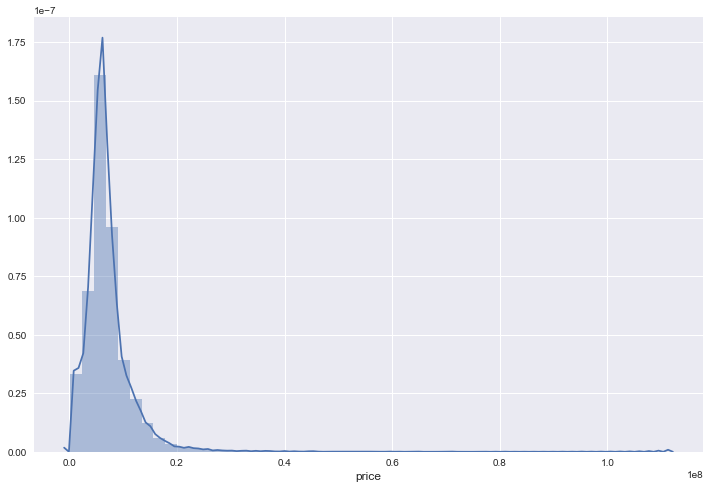

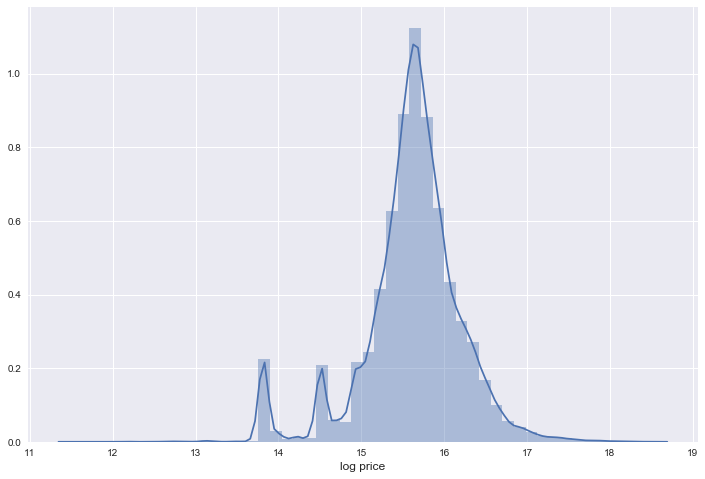

In [3]:
plt.figure(figsize=(12,8))
sns.distplot(train_df.price_doc.values, bins=50, kde=True)
plt.xlabel('price', fontsize=12)
plt.show()

plt.figure(figsize=(12,8))
sns.distplot(np.log(train_df.price_doc.values), bins=50, kde=True)
plt.xlabel('log price', fontsize=12)
plt.show()

Text(0.5,0,'% missing')

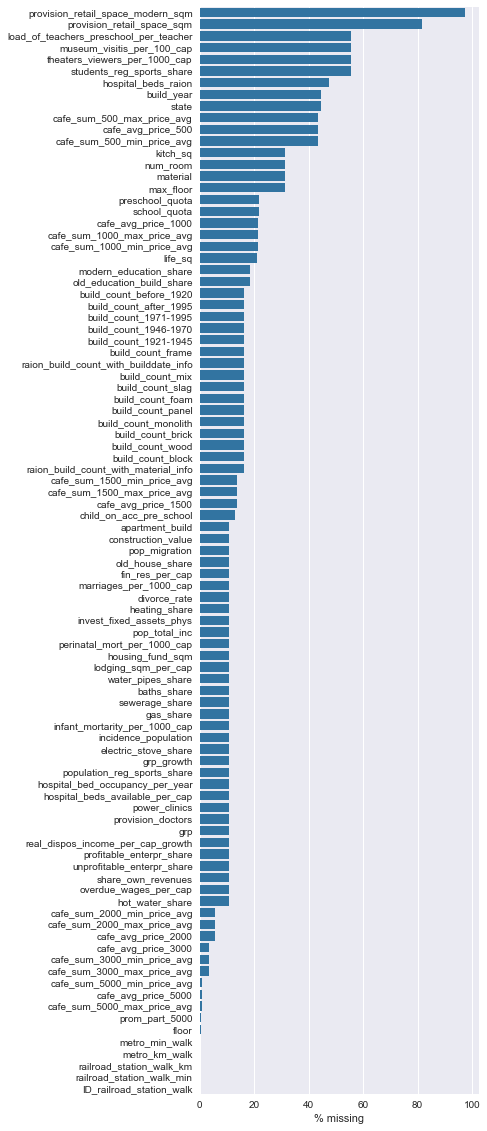

In [4]:
fig = plt.figure(figsize=(5,20))
train_na = (train_df.isnull().sum() / len(train_df)) * 100
train_na = train_na.drop(train_na[train_na == 0].index).sort_values(ascending=False)
sns.barplot(y=train_na.index, x=train_na, color=color[0])
plt.xlabel('% missing')

In [61]:
train_df["build_count_before_1945"] = train_df["build_count_before_1920"] + train_df["build_count_1921-1945"]
train_df["build_count_wood_slag"] = train_df['build_count_wood'] + train_df['build_count_slag']

In [47]:
list(filter(lambda x: "_count_" in x, train_df.columns.tolist()))

['raion_build_count_with_material_info',
 'build_count_block',
 'build_count_wood',
 'build_count_frame',
 'build_count_brick',
 'build_count_monolith',
 'build_count_panel',
 'build_count_foam',
 'build_count_slag',
 'build_count_mix',
 'raion_build_count_with_builddate_info',
 'build_count_before_1920',
 'build_count_1921-1945',
 'build_count_1946-1970',
 'build_count_1971-1995',
 'build_count_after_1995',
 'office_count_500',
 'trc_count_500',
 'cafe_count_500',
 'cafe_count_500_na_price',
 'cafe_count_500_price_500',
 'cafe_count_500_price_1000',
 'cafe_count_500_price_1500',
 'cafe_count_500_price_2500',
 'cafe_count_500_price_4000',
 'cafe_count_500_price_high',
 'big_church_count_500',
 'church_count_500',
 'mosque_count_500',
 'leisure_count_500',
 'sport_count_500',
 'market_count_500',
 'office_count_1000',
 'trc_count_1000',
 'cafe_count_1000',
 'cafe_count_1000_na_price',
 'cafe_count_1000_price_500',
 'cafe_count_1000_price_1000',
 'cafe_count_1000_price_1500',
 'cafe_coun

In [44]:
list(filter(lambda x: "_part_" in x, train_df.columns.tolist()))

['green_part_500',
 'prom_part_500',
 'green_part_1000',
 'prom_part_1000',
 'green_part_1500',
 'prom_part_1500',
 'green_part_2000',
 'prom_part_2000',
 'green_part_3000',
 'prom_part_3000',
 'green_part_5000',
 'prom_part_5000']

In [30]:
USE_FEATURES = [
    "full_sq", "life_sq", "kitch_sq", "num_room",
    "floor", "max_floor", 
    "build_year", "timestamp",
    "product_type", "state", "material", 
    "sub_area",
]

##########################################################
                  prct_non_empty        col_type
full_sq                      1.0           int64
life_sq                      1.0         float64
kitch_sq                     1.0         float64
num_room                     1.0         float64
floor                        1.0         float64
max_floor     0.6858652489252076         float64
build_year    0.5535098946539333         float64
timestamp                    1.0  datetime64[ns]
product_type                 1.0          object
state         0.5550195267631518         float64
material      0.6858652489252076         float64
sub_area                     1.0          object
##########################################################


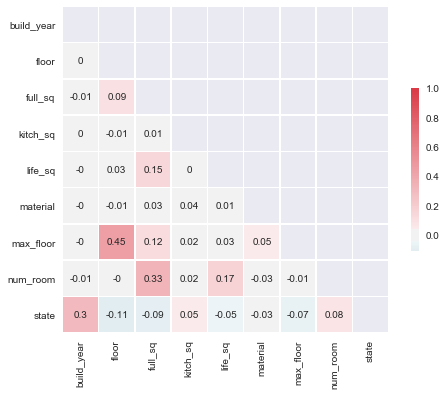

In [31]:
corr_df, empty_info = get_corr_empty_info(df=train_df, cols=USE_FEATURES)

##########################################################
                           prct_non_empty col_type
build_count_block      0.8362049161497818  float64
build_count_frame      0.8362049161497818  float64
build_count_brick      0.8362049161497818  float64
build_count_monolith   0.8362049161497818  float64
build_count_panel      0.8362049161497818  float64
build_count_foam       0.8362049161497818  float64
build_count_wood_slag  0.8362049161497818  float64
##########################################################


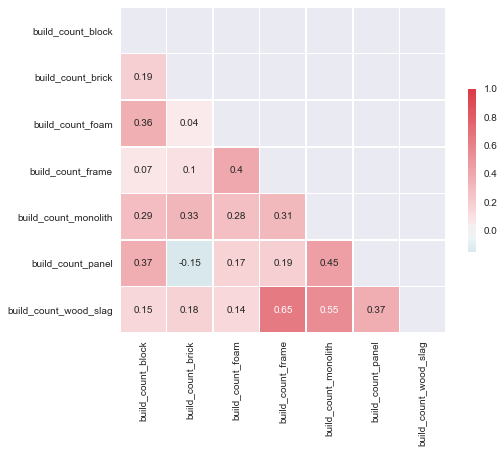

In [73]:
cols = [
#     'raion_build_count_with_material_info',
#     'raion_build_count_with_builddate_info',
#     'build_count_wood',
#     'build_count_slag',
    'build_count_block',
    'build_count_frame',
    'build_count_brick',
    'build_count_monolith',
    'build_count_panel',
    'build_count_foam',
    "build_count_wood_slag",
#     'build_count_mix',
#     'build_count_before_1920',
#     'build_count_1921-1945',
#     "build_count_before_1945",
#     'build_count_1946-1970',
#     'build_count_1971-1995',
#     'build_count_after_1995'
]
corr_df, empty_info = get_corr_empty_info(df=train_df, cols=cols)

In [ ]:
USE_FEATURES += ['build_count_block',
                 'build_count_frame',
                 'build_count_brick',
                 'build_count_monolith',
                 'build_count_panel',
                 'build_count_foam',
                 "build_count_wood_slag"]

##########################################################
                     prct_non_empty col_type
green_part_500                  1.0  float64
prom_part_500                   1.0  float64
green_part_1000                 1.0  float64
prom_part_1000                  1.0  float64
green_part_1500                 1.0  float64
prom_part_1500                  1.0  float64
green_part_2000                 1.0  float64
prom_part_2000                  1.0  float64
green_part_3000                 1.0  float64
prom_part_3000                  1.0  float64
green_part_5000                 1.0  float64
prom_part_5000   0.9941583800991106  float64
##########################################################


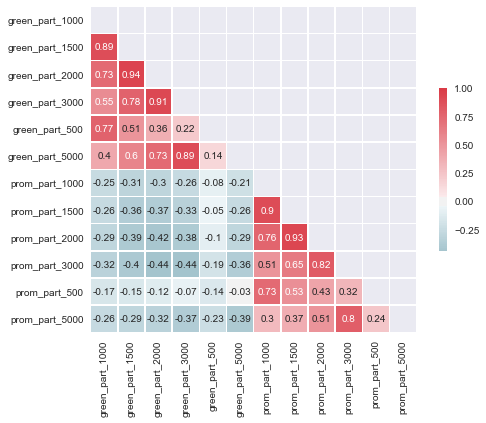

In [74]:
cols = ['green_part_500',
        'prom_part_500',
        'green_part_1000',
        'prom_part_1000',
        'green_part_1500',
        'prom_part_1500',
        'green_part_2000',
        'prom_part_2000',
        'green_part_3000',
        'prom_part_3000',
        'green_part_5000',
        'prom_part_5000']
corr_df, empty_info = get_corr_empty_info(df=train_df, cols=cols)

In [52]:
train_df[sorted(cols)].head(15)

,build_count_1921-1945,build_count_1946-1970,build_count_1971-1995,build_count_after_1995,build_count_before_1920
0,0.0,0.0,206.0,5.0,0.0
1,1.0,143.0,84.0,15.0,1.0
2,0.0,246.0,63.0,20.0,1.0
3,24.0,40.0,130.0,252.0,13.0
4,114.0,146.0,62.0,53.0,371.0
5,5.0,152.0,25.0,6.0,0.0
6,38.0,90.0,58.0,19.0,11.0
7,0.0,0.0,206.0,5.0,0.0
8,9.0,290.0,39.0,51.0,1.0
9,88.0,413.0,94.0,96.0,47.0


In [33]:
train_df_processed = prepare_choosed_features(train_df, USE_FEATURES,
                                              dont_touch_cols=["build_year", "timestamp", "material", "max_floor"])

def manual_processing(df):
    df = df.copy()
    
    df["material0"] = df.material.isnull().astype(int)
    df["material1"] = (df.material==1).astype(int)
    df["material2"] = (df.material==2).astype(int)
    df["material3"] = (df.material==3).astype(int)
    df["material4"] = (df.material==4).astype(int)
    df["material5"] = (df.material==5).astype(int)
    df["material6"] = (df.material==6).astype(int)
    del df["material"]
    
    df["build0"] = (df.build_year==0).astype(int)
    df["build1"] = (df.build_year==1).astype(int)
    df.loc[df.build_year>2030,"build_year"] = np.NaN
    df.loc[df.build_year<1600,"build_year"] = np.NaN
    df["nobuild"] = df.build_year.isnull().astype(int)
    df["transaction_since_build"] = pd.to_datetime(df.timestamp).dt.year - df.build_year
    df.build_year = df.build_year.fillna(df.build_year.mode().values[0])
    df.transaction_since_build = df.transaction_since_build.fillna(df.transaction_since_build.median())
    
    df["floor0"] = (df.floor==0).astype(int)
    df["floor1"] = (df.floor==1).astype(int)
    df["floorhuge"] = (df.floor>40).astype(int)
#    df["lnfloor"] = np.log(df.floor+1)

    df["nomax_floor"] = df.max_floor.isnull().astype(int)
    df.max_floor = df.max_floor.fillna(df.max_floor.median())
    df["max0"] = (df.max_floor==0).astype(int)
    df["max1"] = (df.max_floor==1).astype(int)
    df["maxhuge"] = (df.max_floor>80).astype(int)
#    df["lnmax"] = np.log(df.max_floor+1)
    
    return df

Processing column: full_sq
Processing column: life_sq
Processing column: kitch_sq
Processing column: num_room
Processing column: floor
Processing column: max_floor
Processing column: build_year
Processing column: timestamp
Processing column: product_type
Processing column: state
Processing column: material
Processing column: sub_area
Processing column: raion_build_count_with_material_info
Processing column: build_count_block
Processing column: build_count_wood
Processing column: build_count_frame
Processing column: build_count_brick
Processing column: build_count_monolith
Processing column: build_count_panel
Processing column: build_count_foam
Processing column: build_count_slag
Processing column: build_count_mix
Processing column: raion_build_count_with_builddate_info
Processing column: build_count_before_1920
Processing column: build_count_1921-1945
Processing column: build_count_1946-1970
Processing column: build_count_1971-1995
Processing column: build_count_after_1995
Processing c

In [34]:
train_df_processed = manual_processing(train_df_processed)

##########################################################
                           prct_non_empty col_type
cafe_count_5000_na_price              1.0    int64
cafe_count_5000_price_500             1.0    int64
cafe_count_5000_price_1000            1.0    int64
cafe_count_5000_price_1500            1.0    int64
cafe_count_5000_price_2500            1.0    int64
cafe_count_5000_price_4000            1.0    int64
cafe_count_5000_price_high            1.0    int64
cafe_count_500_na_price               1.0    int64
cafe_count_500_price_500              1.0    int64
cafe_count_500_price_1000             1.0    int64
cafe_count_500_price_1500             1.0    int64
cafe_count_500_price_2500             1.0    int64
cafe_count_500_price_4000             1.0    int64
cafe_count_500_price_high             1.0    int64
##########################################################


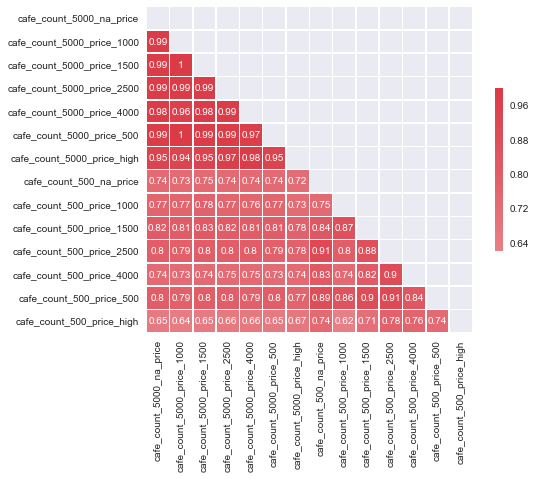

In [35]:
cols=["full_sq", "life_sq", "kitch_sq", "num_room",
      "floor", "max_floor", 
      "build_year", "transaction_since_build",
      "maxhuge", "nomax_floor", "floor0", "floor1", "floorhuge"]

cols = ["cafe_count_5000_na_price", "cafe_count_5000_price_500", "cafe_count_5000_price_1000", "cafe_count_5000_price_1500", 
        "cafe_count_5000_price_2500", "cafe_count_5000_price_4000", "cafe_count_5000_price_high", 
        "cafe_count_500_na_price", "cafe_count_500_price_500", "cafe_count_500_price_1000", "cafe_count_500_price_1500", 
        "cafe_count_500_price_2500", "cafe_count_500_price_4000", "cafe_count_500_price_high"]

corr_df_proc, empty_info_proc = get_corr_empty_info(df=train_df_processed, cols=cols)

In [20]:
X = train_df_processed.copy()
del X["timestamp"]
Y = train_df.price_doc.apply(np.log)

In [26]:
from xgboost import XGBRegressor
from sklearn.model_selection import KFold

def rmsle_exp(y_true_log, y_pred_log):
    y_true = np.exp(y_true_log)
    y_pred = np.exp(y_pred_log)
    return np.sqrt(np.mean(np.power(np.log(y_true + 1) - np.log(y_pred + 1), 2)))


cv = KFold(n_splits=5, random_state=123, shuffle=True)

model = XGBRegressor()

for (train, test), i in zip(cv.split(X, Y), range(5)):
    model.fit(X.iloc[train], Y.iloc[train])
    pred_train = model.predict(X.iloc[train])
    pred_test = model.predict(X.iloc[test])
    
    print("train RMSLE:", rmsle_exp(Y.iloc[train], pred_train))
    print("test RMSLE:", rmsle_exp(Y.iloc[test], pred_test))
    print("-----------------------------")

train RMSLE: 0.47796131135296754
test RMSLE: 0.5005295397414854
-----------------------------
train RMSLE: 0.48202815534080706
test RMSLE: 0.4781628988416375
-----------------------------
train RMSLE: 0.4842293158701784
test RMSLE: 0.4717979851061472
-----------------------------
train RMSLE: 0.4797061581590055
test RMSLE: 0.4866289013175402
-----------------------------
train RMSLE: 0.4778625170212834
test RMSLE: 0.4949500921228033
-----------------------------


In [ ]:
# dfa["fullzero"] = (dfa.full_sq==0)
# dfa["fulltiny"] = (dfa.full_sq<4)
# dfa["fullhuge"] = (dfa.full_sq>2000)
# dfa["lnfull"] = np.log(dfa.full_sq+1)

# dfa["nolife"] = dfa.life_sq.isnull()
# dfa.life_sq = dfa.life_sq.fillna(dfa.life_sq.median())
# dfa["lifezero"] = (dfa.life_sq==0)
# dfa["lifetiny"] = (dfa.life_sq<4)
# dfa["lifehuge"] = (dfa.life_sq>2000)
# dfa["lnlife"] = np.log( dfa.life_sq + 1 )



# dfa["norooms"] = dfa.num_room.isnull()
# dfa.num_room = dfa.num_room.fillna(dfa.num_room.median())
# dfa["zerorooms"] = (dfa.num_room==0)
# dfa["lnrooms"] = np.log( dfa.num_room + 1 )

# dfa["nokitch"] = dfa.kitch_sq.isnull()
# dfa.kitch_sq = dfa.kitch_sq.fillna(dfa.kitch_sq.median())
# dfa["kitch1"] = (dfa.kitch_sq==1)
# dfa["kitch0"] = (dfa.kitch_sq==0)
# dfa["kitchhuge"] = (dfa.kitch_sq>400)
# dfa["lnkitch"] = np.log(dfa.kitch_sq+1)

# # "state" isn't explained but it looks like an ordinal number, so for now keep numeric
# dfa.loc[dfa.state>5,"state"] = np.NaN  # Value 33 seems to be invalid; others all 1-4
# dfa.state = dfa.state.fillna(dfa.state.median())

# # product_type gonna be ugly because there are missing values in the test set but not training
# # Check for the same problem with other variables
# dfa["owner_occ"] = (dfa.product_type=='OwnerOccupier')
# dfa.owner_occ.fillna(dfa.owner_occ.mean())


# # Interaction terms
# dfa["fullzero_Xowner"] = dfa.fullzero.astype("float64") * dfa.owner_occ
# dfa["fulltiny_Xowner"] = dfa.fulltiny.astype("float64") * dfa.owner_occ
# dfa["fullhuge_Xowner"] = dfa.fullhuge.astype("float64") * dfa.owner_occ
# dfa["lnfull_Xowner"] = dfa.lnfull * dfa.owner_occ
# dfa["nofloor_Xowner"] = dfa.nofloor.astype("float64") * dfa.owner_occ
# dfa["floor0_Xowner"] = dfa.floor0.astype("float64") * dfa.owner_occ
# dfa["floor1_Xowner"] = dfa.floor1.astype("float64") * dfa.owner_occ
# dfa["lnfloor_Xowner"] = dfa.lnfloor * dfa.owner_occ
# dfa["max1_Xowner"] = dfa.max1.astype("float64") * dfa.owner_occ
# dfa["max0_Xowner"] = dfa.max0.astype("float64") * dfa.owner_occ
# dfa["maxhuge_Xowner"] = dfa.maxhuge.astype("float64") * dfa.owner_occ
# dfa["lnmax_Xowner"] = dfa.lnmax * dfa.owner_occ
# dfa["kitch1_Xowner"] = dfa.kitch1.astype("float64") * dfa.owner_occ
# dfa["kitch0_Xowner"] = dfa.kitch0.astype("float64") * dfa.owner_occ
# dfa["kitchhuge_Xowner"] = dfa.kitchhuge.astype("float64") * dfa.owner_occ
# dfa["lnkitch_Xowner"] = dfa.lnkitch * dfa.owner_occ
# dfa["nobuild_Xowner"] = dfa.nobuild.astype("float64") * dfa.owner_occ
# dfa["newhouse_Xowner"] = dfa.newhouse.astype("float64") * dfa.owner_occ
# dfa["tooold_Xowner"] = dfa.tooold.astype("float64") * dfa.owner_occ
# dfa["build0_Xowner"] = dfa.build0.astype("float64") * dfa.owner_occ
# dfa["build1_Xowner"] = dfa.build1.astype("float64") * dfa.owner_occ
# dfa["lnsince_Xowner"] = dfa.lnsince * dfa.owner_occ
# dfa["state_Xowner"] = dfa.state * dfa.owner_occ